In [29]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.probability import ConditionalFreqDist
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
plt.style.use("dark_background")

df = pd.read_csv("_data/1_Fast_CrisisNLP_Twitter_Disaster/crisis_aggregated_preprocessed.csv")
df.head()

,event,source,text,class_label,group,cleaned_text,normalized_text
0,disaster_events,drd-figureeight-multimedia,Approximately 100km long firebreaks have been ...,infrastructure_and_utilities_damage,train,approximately km long firebreaks have been con...,approximately km long firebreak constructed in...
1,2015_nepal_earthquake,crisisnlp-volunteers,God bless you... https://t.co/AnEy1ydkkz,not_humanitarian,train,god bless you,god bless
2,2014_california_earthquake,crisisnlp-cf,"RT @perreaux: Cracked wine casks, damaged hist...",infrastructure_and_utilities_damage,train,cracked wine casks damaged historical building...,cracked wine cask damaged historical building ...
3,2013_boston_bombings-ontopic,crisislext6,I'm really just excited for new undies and pin...,not_humanitarian,train,i m really just excited for new undies and pin...,really excited new undies pinkberry
4,2014_pakistan_floods,crisisnlp-cf,"Rescue effort expands in India, Pakistan as fl...",injured_or_dead_people,train,rescue effort expands in india pakistan as flo...,rescue effort expands india pakistan flood dea...


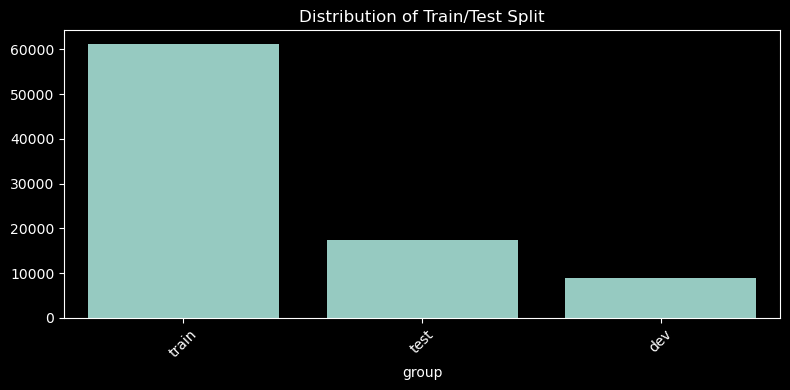

In [30]:
groups = df['group'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=groups.index, y=groups.values)
plt.xticks(rotation=45)
plt.title('Distribution of Train/Test Split')
plt.tight_layout()
plt.show()

In [31]:
text_column = 'normalized_text'

# Filter out rows with NaN values
train_mask = df['group'].isin(['train', 'dev']) & df[text_column].notna()
test_mask = (df['group'] == 'test') & df[text_column].notna()

# Add 'dev' samples to 'train'
X_train = df[train_mask][text_column]
y_train = df[train_mask]['class_label']

X_test = df[test_mask][text_column]
y_test = df[test_mask]['class_label']

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 70089
Test set size: 17354


# Decision Tree

In [32]:
def create_rule_based_classifier(X_train, y_train, feature_names, max_depth=5):
    rules = {}
    trees = {}
    classes = np.unique(y_train)

    for category in classes:
        # Convert to binary classification: this category vs all others
        y_binary = (y_train == category).astype(int)

        # Create a decision tree with controlled depth
        tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        tree.fit(X_train, y_binary)

        # Extract rules as text
        tree_rules = export_text(tree, feature_names=feature_names)

        # Store both the rules and the trained tree
        rules[category] = tree_rules
        trees[category] = tree

    return rules, trees

# Use the trained trees for prediction
def predict_with_trees(X_test, trees, categories):
    predictions = []

    for i in range(X_test.shape[0]):
        sample = X_test[i:i+1]  # Keep sparse format intact

        # Get prediction probability from each category's tree
        category_scores = {}
        for cat in categories:
            # Get probability of positive class (index 1)
            proba = trees[cat].predict_proba(sample)[0][1]
            category_scores[cat] = proba

        # Select category with highest probability
        predicted_category = max(category_scores.items(), key=lambda x: x[1])[0]
        predictions.append(predicted_category)

    return predictions

categories = np.unique(y_train)
tree_rules, trained_trees = create_rule_based_classifier(X_train_tfidf, y_train, feature_names)
y_pred_method1_tfidf = predict_with_trees(X_test_tfidf, trained_trees, categories)
accuracy_method1_tfidf = accuracy_score(y_test, y_pred_method1_tfidf)
print(f"\nMethod 1 (TF-IDF) Accuracy: {accuracy_method1_tfidf:.4f}")
print(classification_report(y_test, y_pred_method1_tfidf))


Method 1 (TF-IDF) Accuracy: 0.6836
                                     precision    recall  f1-score   support

                affected_individual       0.79      0.20      0.32       692
                 caution_and_advice       0.75      0.25      0.37       583
          displaced_and_evacuations       0.56      0.10      0.17        99
          donation_and_volunteering       0.57      0.39      0.46      1452
infrastructure_and_utilities_damage       0.74      0.15      0.25      1002
             injured_or_dead_people       0.78      0.42      0.54       561
           missing_and_found_people       0.52      0.13      0.20       103
                   not_humanitarian       0.68      0.97      0.80     10251
                  requests_or_needs       0.73      0.35      0.48      1370
                   response_efforts       0.40      0.01      0.02       221
               sympathy_and_support       0.73      0.21      0.32      1020

                           accuracy   

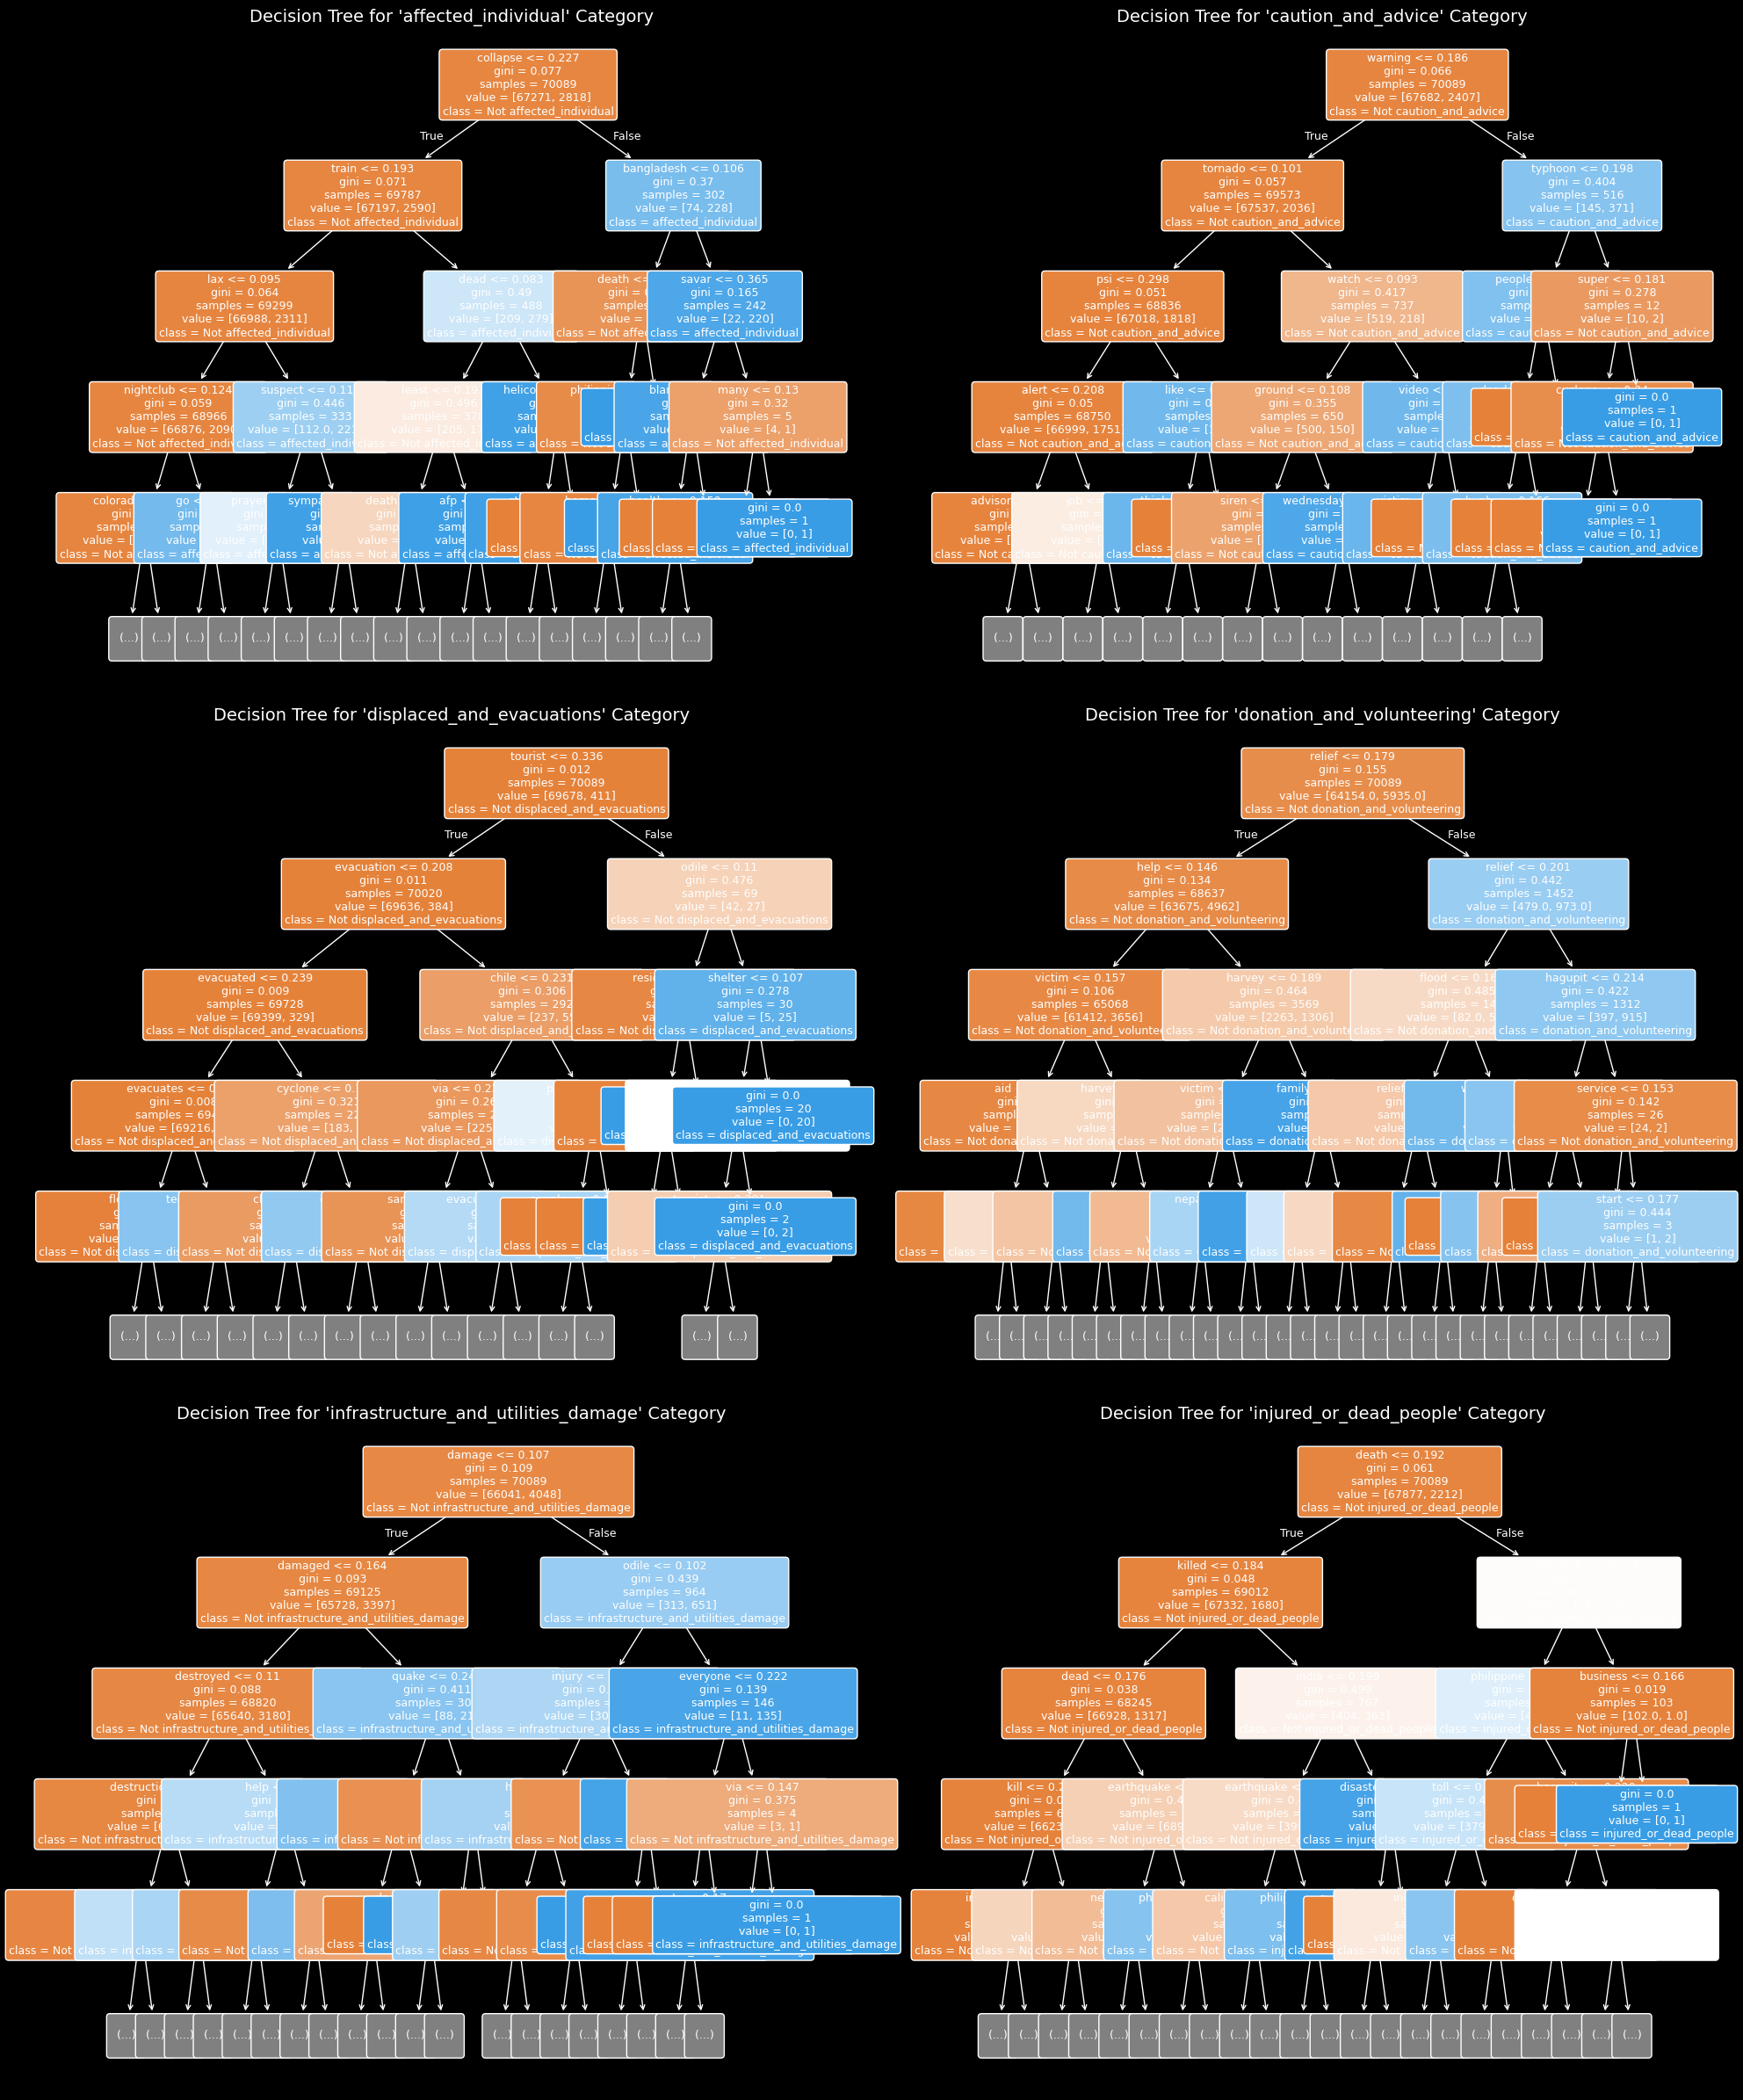

In [33]:
import matplotlib.pyplot as plt
from sklearn import tree

fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()

for i, category in enumerate(categories):
    if i < len(axes):  # Make sure we don't go out of bounds
        # Plot tree on the corresponding subplot
        tree.plot_tree(
            trained_trees[category],
            feature_names=feature_names,
            filled=True,
            rounded=True,
            class_names=["Not " + category, category],
            fontsize=9,
            max_depth=4, # readability
            ax=axes[i]
        )
        axes[i].set_title(f"Decision Tree for '{category}' Category", fontsize=14)

for i in range(len(categories), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# KEYWORD-BASED CLASSIFICATION

In [34]:
def extract_top_keywords(vectorizer, X_train, y_train, n_keywords=15):
    feature_names = vectorizer.get_feature_names_out()
    keywords_dict = {}

    # Group documents by category
    for category in np.unique(y_train):
        # Get indices of documents in this category
        category_indices = np.where(y_train == category)[0]

        if len(category_indices) > 0:
            # Sum TF-IDF values for each word across all documents in this category
            category_tfidf = X_train[category_indices].sum(axis=0)

            # Convert to array and sort by decreasing importance
            category_tfidf = np.asarray(category_tfidf).flatten()
            top_indices = category_tfidf.argsort()[-n_keywords:][::-1]

            # Get the corresponding words
            top_words = [feature_names[i] for i in top_indices]
            keywords_dict[category] = top_words

    return keywords_dict

# 1. For each category (business, entertainment, etc.), we find which words have the highest TF-IDF scores
# 2. We sum TF-IDF values across all documents in each category to identify the most important words
# 3. We select the top N words (20 in this case) for each category
# 4. The result is a dictionary where each category maps to its most distinctive words
keyword_dict = extract_top_keywords(tfidf_vectorizer, X_train_tfidf, y_train, n_keywords=20)
print("Top keywords for each category:")
for category, keywords in keyword_dict.items():
    print(f"{category}: {', '.join(keywords)}")

# Function to predict with keyword matching
def predict_with_keywords(texts, keywords_dict):
    predictions = []

    for text in texts:
        # Count keyword occurrences for each category
        scores = {}
        for category, words in keywords_dict.items():
            score = sum(text.count(word) for word in words)
            scores[category] = score

        # Predict the category with highest keyword count
        if max(scores.values()) > 0:
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
        else:
            predictions.append("unknown")  # If no keywords match

    return predictions

# 1. For each document in the test set, we count how many times each keyword appears
# 2. For example, if a document contains "film" 3 times, "award" 2 times, and "music" 1 time, the score for "entertainment" would be 6
# 3. We calculate a score for each category by summing the counts of all keywords
# 4. The document is assigned to the category with the highest keyword count
# 5. If no keywords are found, it's labeled as "unknown" (in this case its impossible)
y_pred_method2 = predict_with_keywords(X_test, keyword_dict)
accuracy_method2 = accuracy_score(y_test, y_pred_method2)
print(f"\nMethod 2 Accuracy: {accuracy_method2:.4f}")
print(classification_report(y_test, y_pred_method2))
# It's essentially a simplified version of a Naive Bayes classifier, but using only the most important words rather than the entire vocabulary.

Top keywords for each category:
affected_individual: dead, people, bangladesh, train, toll, death, collapse, least, killed, lax, colorado, injured, fire, crash, philippine, building, derailment, news, explosion, kill
caution_and_advice: warning, tornado, tsunami, chile, earthquake, typhoon, pm, flood, alert, storm, watch, bigwet, hit, issued, rubyph, update, area, philippine, emergency, fire
displaced_and_evacuations: flood, evacuation, evacuated, thousand, shelter, people, chile, tourist, resident, odile, kashmir, hit, earthquake, nepal, hagupit, hurricane, typhoon, philippine, flee, yemen
donation_and_volunteering: help, relief, victim, harvey, hurricane, irma, donate, aid, earthquake, puerto, flood, rico, nepal, amp, donation, effort, need, affected, volunteer, rescue
infrastructure_and_utilities_damage: damage, hurricane, earthquake, irma, home, power, damaged, california, destroyed, flood, building, odile, harvey, destruction, road, napa, house, photo, cyclone, via
injured_or_dead

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [35]:
# Define manual keywords for each category based on your provided keywords
manual_keywords = {
    'affected_individual': ['dead', 'people', 'bangladesh', 'train', 'toll', 'death', 'collapse',
                            'least', 'killed', 'lax', 'colorado', 'injured', 'fire', 'crash',
                            'philippine', 'building', 'derailment', 'news', 'explosion', 'kill'],

    'caution_and_advice': ['warning', 'tornado', 'tsunami', 'chile', 'earthquake', 'typhoon',
                          'pm', 'flood', 'alert', 'storm', 'watch', 'bigwet', 'hit', 'issued',
                          'rubyph', 'update', 'area', 'philippine', 'emergency', 'fire'],

    'displaced_and_evacuations': ['flood', 'evacuation', 'evacuated', 'thousand', 'shelter',
                                 'people', 'chile', 'tourist', 'resident', 'odile', 'kashmir',
                                 'hit', 'earthquake', 'nepal', 'hagupit', 'hurricane', 'typhoon',
                                 'philippine', 'flee', 'yemen'],

    'donation_and_volunteering': ['help', 'relief', 'victim', 'harvey', 'hurricane', 'irma',
                                 'donate', 'aid', 'earthquake', 'puerto', 'flood', 'rico',
                                 'nepal', 'amp', 'donation', 'effort', 'need', 'affected',
                                 'volunteer', 'rescue'],

    'infrastructure_and_utilities_damage': ['damage', 'hurricane', 'earthquake', 'irma', 'home',
                                           'power', 'damaged', 'california', 'destroyed', 'flood',
                                           'building', 'odile', 'harvey', 'destruction', 'road',
                                           'napa', 'house', 'photo', 'cyclone', 'via'],

    'injured_or_dead_people': ['death', 'earthquake', 'toll', 'dead', 'killed', 'india', 'nepal',
                              'flood', 'pakistan', 'people', 'least', 'kill', 'injured', 'quake',
                              'rise', 'california', 'hit', 'chile', 'news', 'magnitude'],

    'missing_and_found_people': ['missing', 'nepal', 'flood', 'earthquake', 'stranded', 'kashmir',
                               'rubble', 'trapped', 'rescued', 'still', 'nepalearthquake', 'people',
                               'joplin', 'help', 'rescue', 'family', 'alive', 'baby', 'nepalquake',
                               'survivor'],

    'not_humanitarian': ['nepal', 'rubyph', 'like', 'love', 'get', 'amp', 'go', 'day', 'good',
                        'know', 'one', 'lol', 'time', 'hagupit', 'god', 'got', 'people', 'typhoon',
                        'philippine', 'want'],

    'requests_or_needs': ['food', 'need', 'help', 'water', 'please', 'tent', 'people', 'find',
                         'aid', 'earthquake', 'area', 'shelter', 'supply', 'would', 'family',
                         'like', 'child', 'victim', 'thank', 'information'],

    'response_efforts': ['nepal', 'nepalearthquake', 'help', 'hagupit', 'nepalquake', 'typhoon',
                        'donate', 'philippine', 'earthquake', 'via', 'relief', 'nepalquakerelief',
                        'amp', 'team', 'donation', 'rubyph', 'aid', 'indian', 'people', 'please'],

    'sympathy_and_support': ['prayer', 'thought', 'pray', 'earthquake', 'everyone', 'prayforchile',
                            'nepal', 'affected', 'safe', 'people', 'praying', 'chile', 'go', 'god',
                            'hope', 'please', 'amp', 'victim', 'family', 'prayforboston']
}

# Function to calculate scores for each category
def score_with_manual_keywords(texts, keywords_dict, return_scores=False):
    predictions = []
    all_scores = []

    for text in texts:
        # Calculate score for each category
        scores = {}
        for category, keywords in keywords_dict.items():
            # Convert text to lowercase for case-insensitive matching
            text_lower = text.lower()
            # Count occurrences of each keyword
            score = sum(text_lower.count(word.lower()) for word in keywords)
            scores[category] = score

        # Store all scores if requested
        if return_scores:
            all_scores.append(scores)

        # Predict category with highest score
        if max(scores.values()) > 0:
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
        else:
            predictions.append("unknown")

    if return_scores:
        return predictions, all_scores
    else:
        return predictions

# Make predictions and get scores
y_pred_manual, all_scores = score_with_manual_keywords(X_test, manual_keywords, return_scores=True)

from sklearn.metrics import accuracy_score, classification_report

accuracy_manual = accuracy_score(y_test, y_pred_manual)
print(f"Manual Keywords Method Accuracy: {accuracy_manual:.4f}")
print(classification_report(y_test, y_pred_manual))

print("\nScore distribution for 5 example documents:")
for i in range(min(5, len(X_test))):
    print(f"\nDocument {i+1} (True category: {y_test.iloc[i]}, Predicted: {y_pred_manual[i]})")
    print(f"Text preview: {X_test.iloc[i][:100]}...")
    print("Category scores:")
    for category, score in sorted(all_scores[i].items(), key=lambda x: x[1], reverse=True):
        print(f"  {category}: {score}")

Manual Keywords Method Accuracy: 0.3929
                                     precision    recall  f1-score   support

                affected_individual       0.30      0.55      0.39       692
                 caution_and_advice       0.19      0.53      0.28       583
          displaced_and_evacuations       0.05      0.42      0.10        99
          donation_and_volunteering       0.36      0.59      0.45      1452
infrastructure_and_utilities_damage       0.37      0.33      0.35      1002
             injured_or_dead_people       0.28      0.58      0.38       561
           missing_and_found_people       0.09      0.30      0.14       103
                   not_humanitarian       0.85      0.34      0.48     10251
                  requests_or_needs       0.56      0.43      0.49      1370
                   response_efforts       0.13      0.20      0.15       221
               sympathy_and_support       0.50      0.44      0.47      1020
                            unknown

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Weighted Keywords Method Accuracy: 0.4230
                                     precision    recall  f1-score   support

                affected_individual       0.32      0.46      0.38       692
                 caution_and_advice       0.23      0.58      0.33       583
          displaced_and_evacuations       0.08      0.48      0.14        99
          donation_and_volunteering       0.49      0.43      0.46      1452
infrastructure_and_utilities_damage       0.39      0.39      0.39      1002
             injured_or_dead_people       0.32      0.53      0.40       561
           missing_and_found_people       0.07      0.46      0.12       103
                   not_humanitarian       0.87      0.38      0.53     10251
                  requests_or_needs       0.44      0.52      0.48      1370
                   response_efforts       0.10      0.18      0.13       221
               sympathy_and_support       0.41      0.58      0.48      1020
                            unkno

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

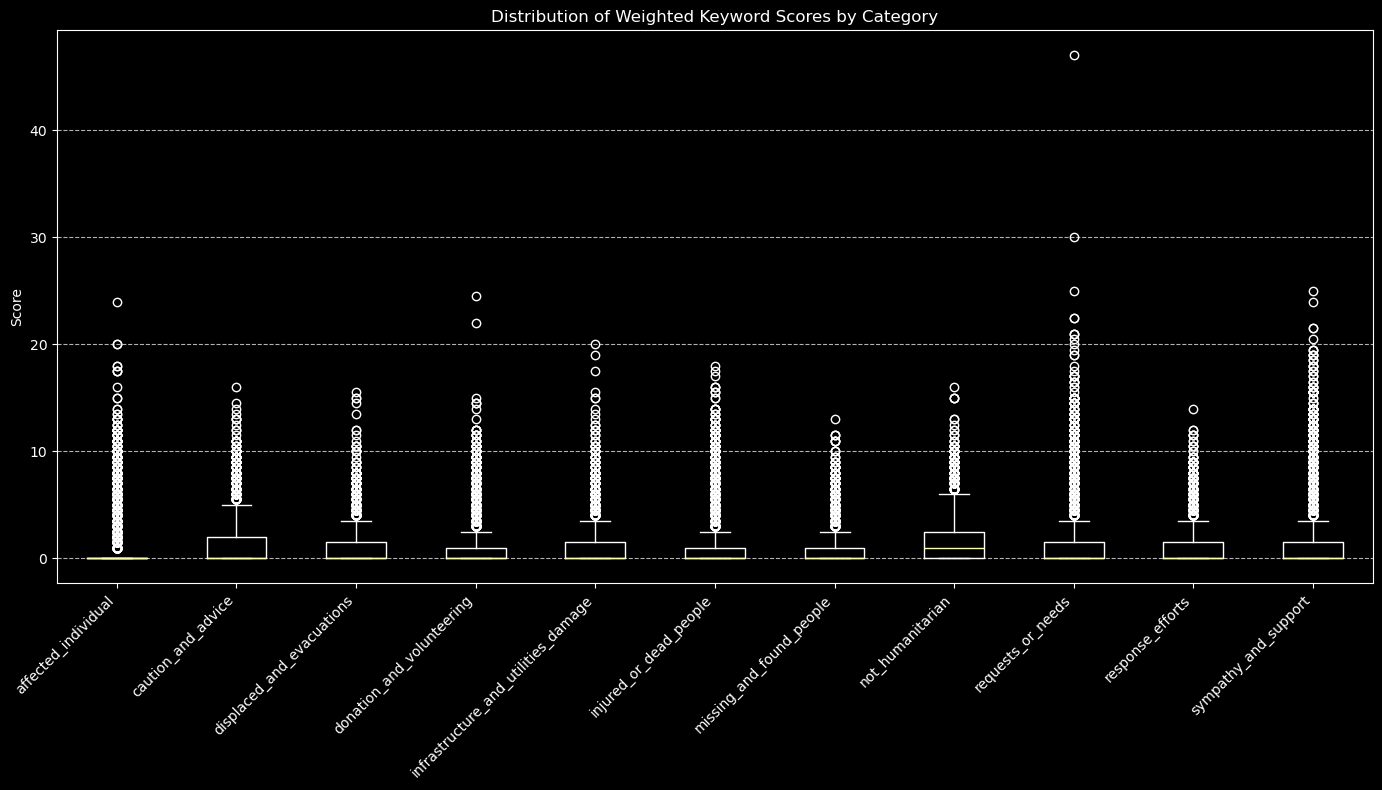

In [36]:
# Define weighted keywords for each category
weighted_keywords = {
    'affected_individual': {
        'dead': 3.0, 'people': 2.0, 'train': 1.5, 'toll': 2.5,
        'death': 3.0, 'collapse': 2.5, 'least': 1.5, 'killed': 3.0, 'lax': 1.5,
        'injured': 2.5, 'fire': 2.0, 'crash': 2.5,
        'building': 2.0, 'derailment': 2.0, 'news': 1.0, 'explosion': 2.5, 'kill': 3.0
    },

    'caution_and_advice': {
        'warning': 3.0, 'tornado': 2.5, 'tsunami': 2.5, 'earthquake': 2.0,
        'typhoon': 2.5, 'pm': 1.0, 'flood': 2.5, 'alert': 3.0, 'storm': 2.5,
        'watch': 2.0, 'bigwet': 1.5, 'hit': 1.5, 'issued': 2.0,
        'update': 2.0, 'area': 1.5, 'emergency': 3.0, 'fire': 2.0,
        'evacuation': 2.5, 'caution': 3.0, 'advisory': 2.5, 'prepare': 2.0
    },

    'displaced_and_evacuations': {
        'flood': 2.5, 'evacuation': 3.0, 'evacuated': 3.0, 'thousand': 2.0, 'shelter': 2.5,
        'people': 1.5, 'chile': 1.0, 'tourist': 2.0, 'resident': 2.5, 'odile': 1.5,
        'hit': 1.0, 'earthquake': 1.5,
        'hurricane': 2.0, 'typhoon': 2.0, 'flee': 2.5, 'yemen': 1.5,
        'displaced': 3.0, 'stranded': 2.5, 'homes': 2.0, 'relocate': 2.5
    },

    'donation_and_volunteering': {
        'help': 2.0, 'relief': 2.5, 'victim': 2.0,
        'irma': 1.5, 'donate': 3.0, 'aid': 2.5, 'earthquake': 1.0,
        'flood': 1.0, 'amp': 1.0, 'donation': 3.0,
        'effort': 2.0, 'need': 2.0, 'affected': 2.0, 'volunteer': 3.0, 'rescue': 2.0,
        'charity': 2.5, 'fundraiser': 2.5, 'support': 2.0, 'contribute': 2.5
    },

    'infrastructure_and_utilities_damage': {
        'damage': 3.0, 'hurricane': 2.0, 'earthquake': 1.5, 'home': 2.0,
        'power': 2.5, 'damaged': 3.0, 'destroyed': 2.5, 'flood': 1.5,
        'building': 2.5, 'destruction': 2.5, 'road': 2.5,
        'napa': 1.0, 'house': 2.0, 'photo': 1.0, 'cyclone': 1.5, 'via': 1.0,
        'infrastructure': 3.0, 'collapse': 2.5, 'bridge': 2.5, 'utility': 2.5, 'outage': 2.5
    },

    'injured_or_dead_people': {
        'death': 3.0, 'earthquake': 1.5, 'toll': 2.5, 'dead': 3.0, 'killed': 3.0,
        'flood': 1.0, 'people': 1.5,
        'least': 1.5, 'kill': 3.0, 'injured': 3.0, 'quake': 1.5, 'rise': 1.5,
        'hit': 1.0, 'chile': 1.0, 'news': 1.0, 'magnitude': 1.5,
        'casualty': 2.5, 'wound': 2.5, 'victim': 2.0, 'hurt': 2.5, 'hospital': 2.0
    },

    'missing_and_found_people': {
        'missing': 3.0, 'nepal': 1.0, 'flood': 1.0, 'earthquake': 1.0, 'stranded': 2.5,
        'kashmir': 1.0, 'rubble': 2.5, 'trapped': 2.5, 'rescued': 2.5, 'still': 1.5,
         'people': 1.5, 'joplin': 1.0, 'help': 1.5, 'rescue': 2.5,
        'family': 2.0, 'alive': 2.5, 'baby': 2.0, 'nepalquake': 1.0, 'survivor': 2.5,
        'found': 2.5, 'search': 2.5, 'locate': 2.5, 'disappeared': 2.5, 'reunited': 2.0
    },

    'not_humanitarian': {
        'nepal': 1.0, 'rubyph': 1.0, 'like': 1.5, 'love': 1.5, 'get': 1.5,
        'amp': 1.5, 'go': 1.5, 'day': 1.5, 'good': 1.5, 'know': 1.5,
        'one': 1.5, 'lol': 2.5, 'time': 1.5, 'hagupit': 1.0, 'god': 1.5,
        'got': 1.5, 'people': 1.0, 'typhoon': 1.0, 'want': 1.5,
        'great': 1.5, 'today': 1.5, 'fun': 2.0, 'happy': 2.0, 'new': 1.5
    },

    'requests_or_needs': {
        'food': 3.0, 'need': 3.0, 'help': 2.0, 'water': 3.0, 'please': 2.0,
        'tent': 2.5, 'people': 1.0, 'find': 2.0, 'aid': 2.5, 'earthquake': 1.0,
        'area': 1.5, 'shelter': 2.5, 'supply': 2.5, 'would': 1.5, 'family': 1.5,
        'like': 1.0, 'child': 2.0, 'victim': 2.0, 'thank': 1.0, 'information': 2.0,
        'request': 3.0, 'urgent': 2.5, 'medicine': 2.5, 'blanket': 2.5, 'assistance': 2.5
    },

    'response_efforts': {
        'help': 2.0, 'hagupit': 1.0, 'nepalquake': 1.5,
        'typhoon': 1.5, 'donate': 2.0, 'earthquake': 1.5, 'via': 1.0,
        'relief': 2.5, 'amp': 1.0, 'team': 2.0, 'donation': 2.0,
        'rubyph': 1.0, 'aid': 2.5, 'indian': 1.0, 'people': 1.0, 'please': 1.0,
        'response': 3.0, 'emergency': 2.0, 'rescue': 2.5, 'operation': 2.5, 'coordination': 2.0
    },

    'sympathy_and_support': {
        'prayer': 3.0, 'thought': 2.5, 'pray': 3.0, 'earthquake': 1.0, 'everyone': 1.5,
        'prayforchile': 2.5, 'nepal': 1.0, 'affected': 2.0, 'safe': 2.0, 'people': 1.0,
        'praying': 3.0, 'chile': 1.0, 'go': 1.0, 'god': 2.0, 'hope': 2.5,
        'please': 1.5, 'amp': 1.0, 'victim': 1.5, 'family': 1.5,
        'sympathy': 3.0, 'condolence': 3.0, 'heart': 2.0, 'sorrow': 2.5, 'strength': 2.0
    }
}

# Function to calculate weighted scores for each category
def score_with_weighted_keywords(texts, weighted_keywords, return_scores=False):
    predictions = []
    all_scores = []

    for text in texts:
        # Calculate weighted score for each category
        scores = {}
        text_lower = text.lower()  # Convert to lowercase for case-insensitive matching

        for category, word_weights in weighted_keywords.items():
            # Sum of (word count * weight) for each keyword
            score = sum(text_lower.count(word.lower()) * weight
                        for word, weight in word_weights.items())
            scores[category] = score

        # Store all scores if requested
        if return_scores:
            all_scores.append(scores)

        # Predict category with highest score
        if max(scores.values()) > 0:
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
        else:
            predictions.append("unknown")

    if return_scores:
        return predictions, all_scores
    else:
        return predictions

# Make predictions and get scores
y_pred_weighted, all_weighted_scores = score_with_weighted_keywords(X_test, weighted_keywords, return_scores=True)

from sklearn.metrics import accuracy_score, classification_report

accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
print(f"Weighted Keywords Method Accuracy: {accuracy_weighted:.4f}")
print(classification_report(y_test, y_pred_weighted))

print("\nWeighted score distribution for 5 example documents:")
for i in range(min(5, len(X_test))):
    print(f"\nDocument {i+1} (True category: {y_test.iloc[i]}, Predicted: {y_pred_weighted[i]})")
    print(f"Text preview: {X_test.iloc[i][:100]}...")
    print("Category scores:")
    for category, score in sorted(all_weighted_scores[i].items(), key=lambda x: x[1], reverse=True):
        print(f"  {category}: {score:.2f}")

# Visualize the weighted scores for misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred_weighted)) if true != pred]

if misclassified_indices:
    print(f"\nAnalyzing {min(5, len(misclassified_indices))} misclassified examples:")
    for idx in misclassified_indices[:5]:  # Look at up to 5 misclassified examples
        print(f"\nMisclassified Document (True: {y_test.iloc[idx]}, Predicted: {y_pred_weighted[idx]})")
        print(f"Text preview: {X_test.iloc[idx][:150]}...")
        print("Category scores:")
        for category, score in sorted(all_weighted_scores[idx].items(), key=lambda x: x[1], reverse=True):
            print(f"  {category}: {score:.2f}")
        print("-" * 50)

# Optionally add visualization, if matplotlib is available
try:
    import matplotlib.pyplot as plt

    # Plot the distribution of scores across categories
    plt.figure(figsize=(14, 8))
    categories = list(weighted_keywords.keys())

    score_data = {cat: [] for cat in categories}
    for i in range(len(y_test)):
        for category in categories:
            score_data[category].append(all_weighted_scores[i][category])

    plt.boxplot([score_data[cat] for cat in categories], labels=categories)
    plt.title('Distribution of Weighted Keyword Scores by Category')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib not available for visualization")

# CONDITIONAL FREQUENCY DISTRIBUTION

In [37]:
# 1. The function builds a ConditionalFreqDist object, which tracks how frequently each word appears in each category
# 2. For each document in our training set, it counts word occurrences by category
# 3. After counting all words, it identifies words that are strongly associated with specific categories
# 4. For each word, it calculates what proportion of its occurrences are in a particular category
# 5. Words are considered "distinctive" if: They appear at least min_count times in a category (default 10)
#    AND at least distinctiveness proportion of their occurrences (default 70%) are in that category
# 6. The result is a dictionary where each category is mapped to words that are strongly associated with it
# 7. These words are automatically discovered from the data, rather than manually defined
# 8. The function then uses these automatically discovered keywords with the same prediction method as method KEYWORD-BASED CLASSIFICATION
def build_cfd_model(texts, categories, min_count=10, distinctiveness=0.7):
    # Download NLTK tokenizer if not available
    try:
        nltk.word_tokenize("test")
    except:
        nltk.download('punkt')

    # Create a conditional frequency distribution
    cfd = ConditionalFreqDist()

    # Count word frequencies by category
    for text, category in zip(texts, categories):
        words = text.split()  # Simple tokenization for preprocessed text
        for word in words:
            if len(word) > 2:  # Skip very short words
                cfd[category][word] += 1

    # Find distinctive words (appear mostly in one category)
    category_keywords = {}
    for category in set(categories):
        category_keywords[category] = []
        for word in cfd[category].keys():
            # Check if this word appears much more in this category
            category_count = cfd[category][word]
            total_count = sum(cfd[cat][word] for cat in set(categories))
            if category_count > min_count and (category_count / total_count) > distinctiveness:
                category_keywords[category].append(word)

    return category_keywords

# Build the CFD model
cfd_keywords = build_cfd_model(X_train, y_train)

print("CFD-derived keywords for each category:")
for category, keywords in cfd_keywords.items():
    print(f"{category}: {', '.join(keywords[:20])}")

y_pred_method3 = predict_with_keywords(X_test, cfd_keywords)
accuracy_method3 = accuracy_score(y_test, y_pred_method3)
print(f"\nMethod 3 Accuracy: {accuracy_method3:.4f}")
print(classification_report(y_test, y_pred_method3))

CFD-derived keywords for each category:
infrastructure_and_utilities_damage: damaged, infrastructure, qaeda, seizes, restored, structural, toppled, uprooted, collapsing, extensive, destroys, winery, kilometre, disrupted, stormfrank
not_humanitarian: really, excited, good, thing, done, hagupit, think, damn, bruh, man, get, outta, compare, gym, time, back, prayforthephilippines, comin, miss, blame
injured_or_dead_people: 
caution_and_advice: warning, issued, psi, unhealthy
response_efforts: 
affected_individual: factory, collapse, nightclub, injures, injuring, derails, gunman, tsa, unaccounted, derailed, guatemala, garment, shooter, suspect, custody, ciancia
missing_and_found_people: 
displaced_and_evacuations: evacuates
sympathy_and_support: prayforvisayas, prayforwest, prayforchile, prayforboston, prayformh, prayforcebu, prayforbohol, prayfortexas, prayforphilippines, bangonpilipinas, prayforsouthkorea, prayforindonesia, prayfornigeria, prayforsinabung
requests_or_needs: paix, refugee,

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

# Summary

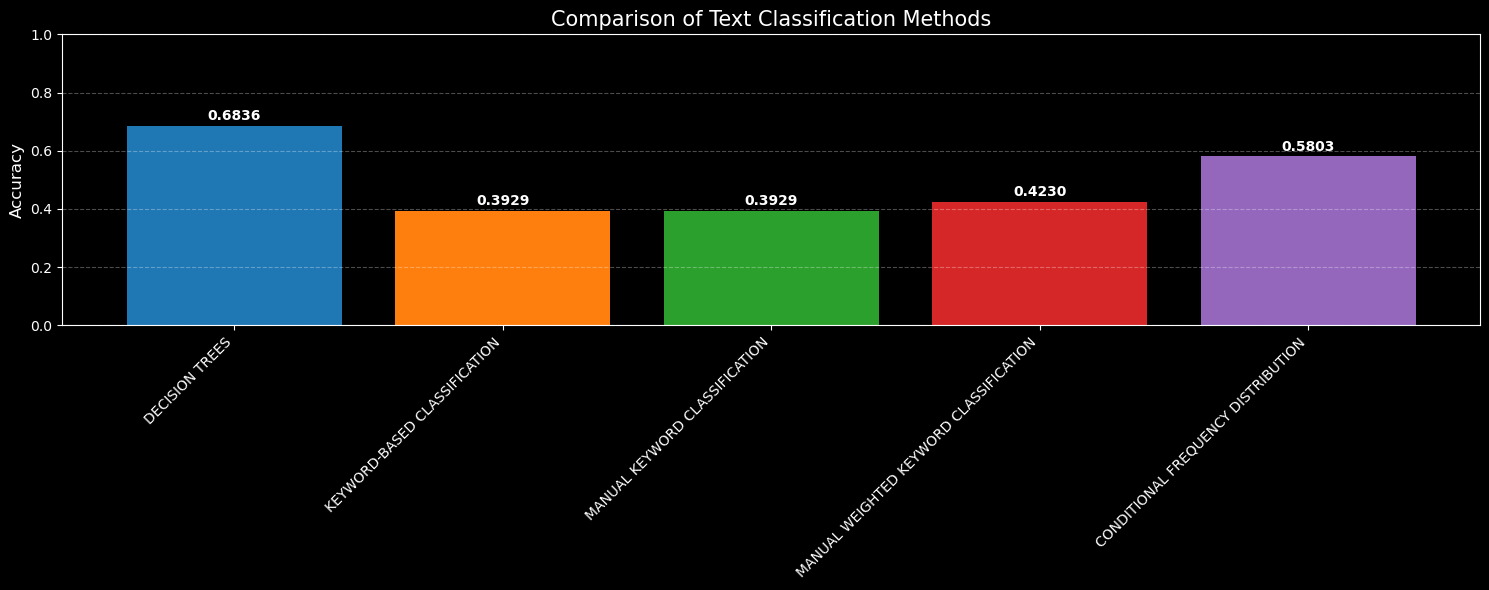

C:\Users\andras.janko\AppData\Local\Temp\ipykernel_1684\3884387593.py:37: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
C:\Users\andras.janko\AppData\Local\Temp\ipykernel_1684\3884387593.py:37: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
C:\Users\andras.janko\AppData\Local\Temp\ipykernel_1684\3884387593.py:37: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
C:\Users\andras.janko\AppData\Local\Temp\ipykernel_1684\3884387593.py:37: RuntimeWarning: invalid value encountered in divide
  class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)


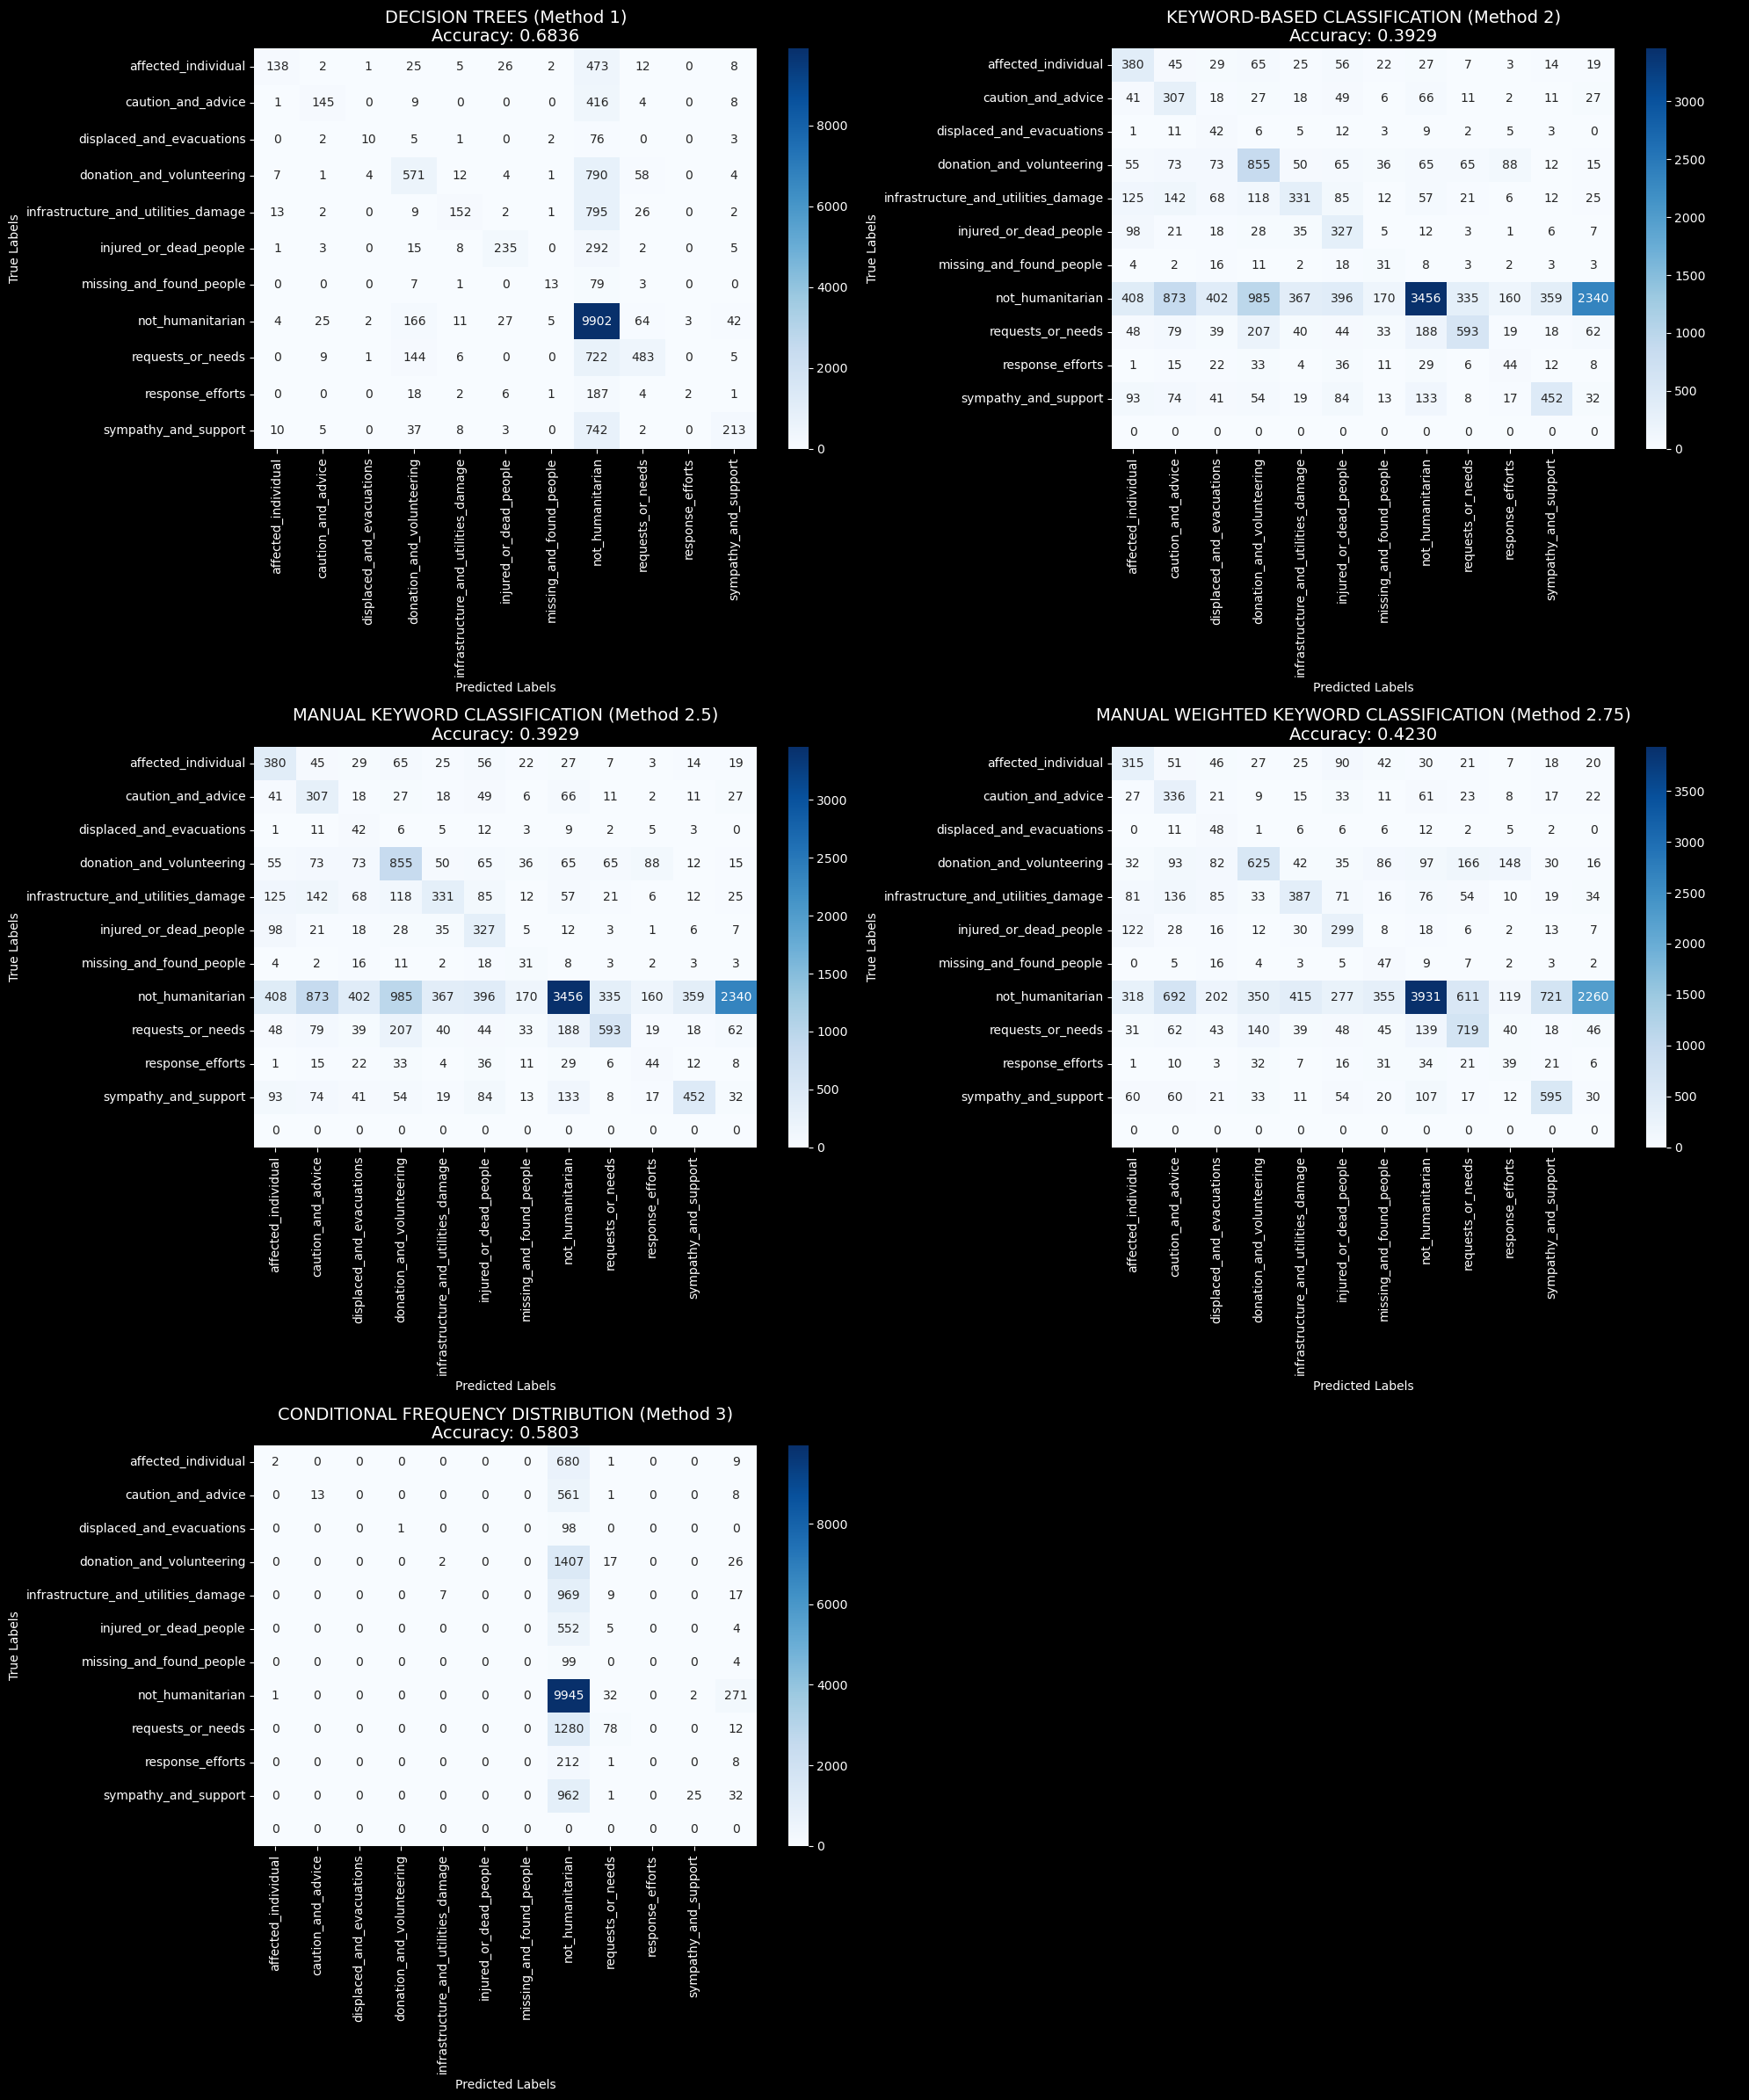

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

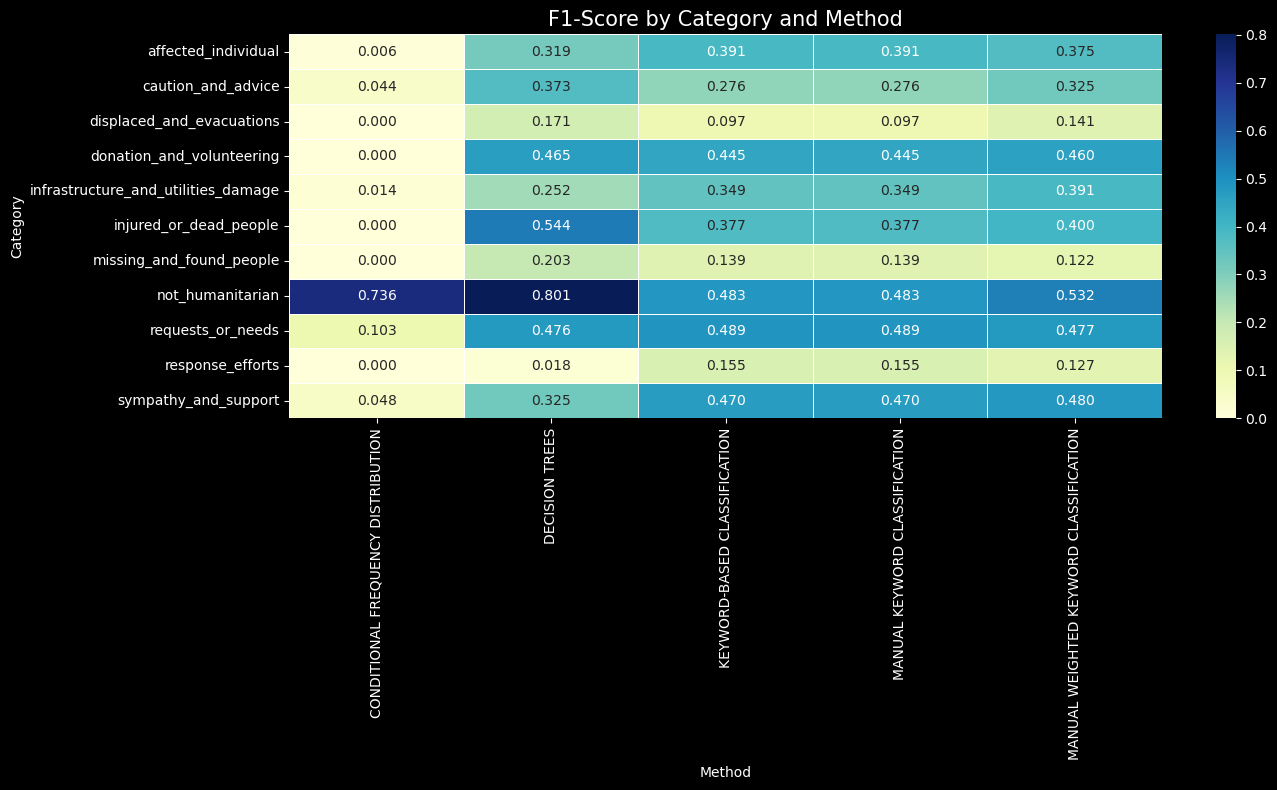

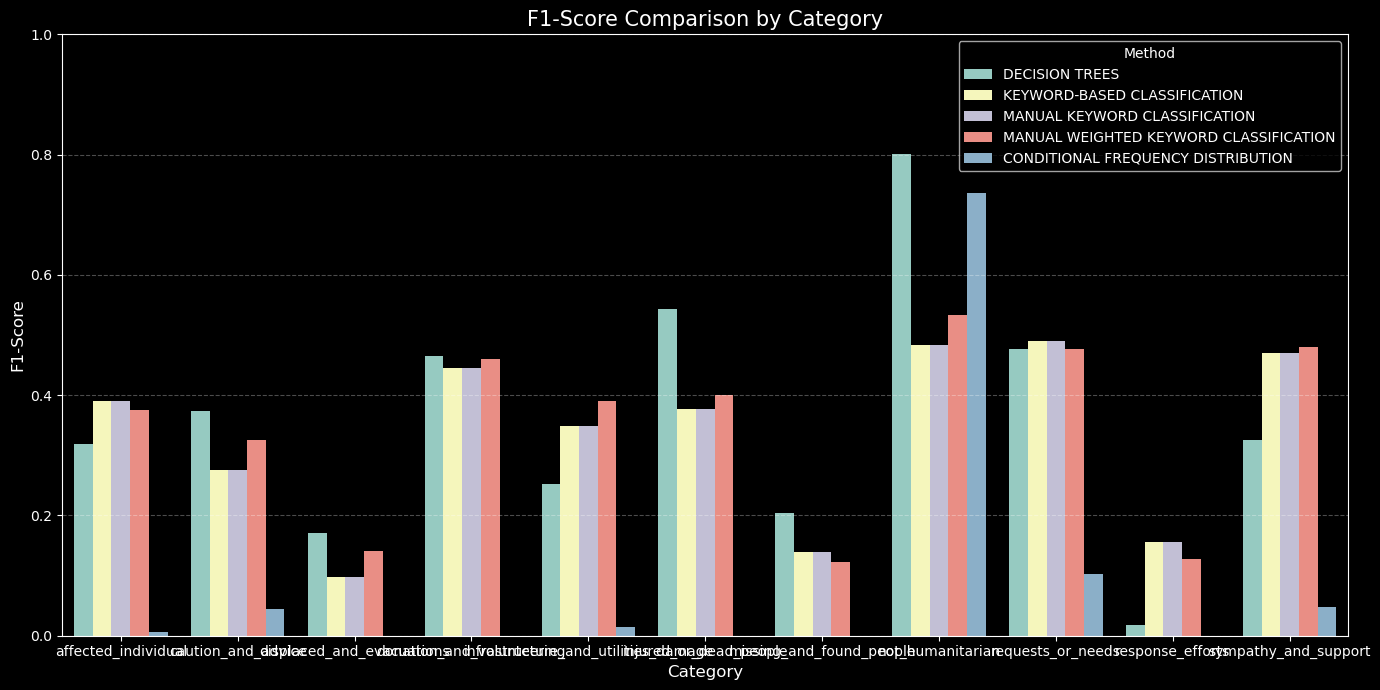

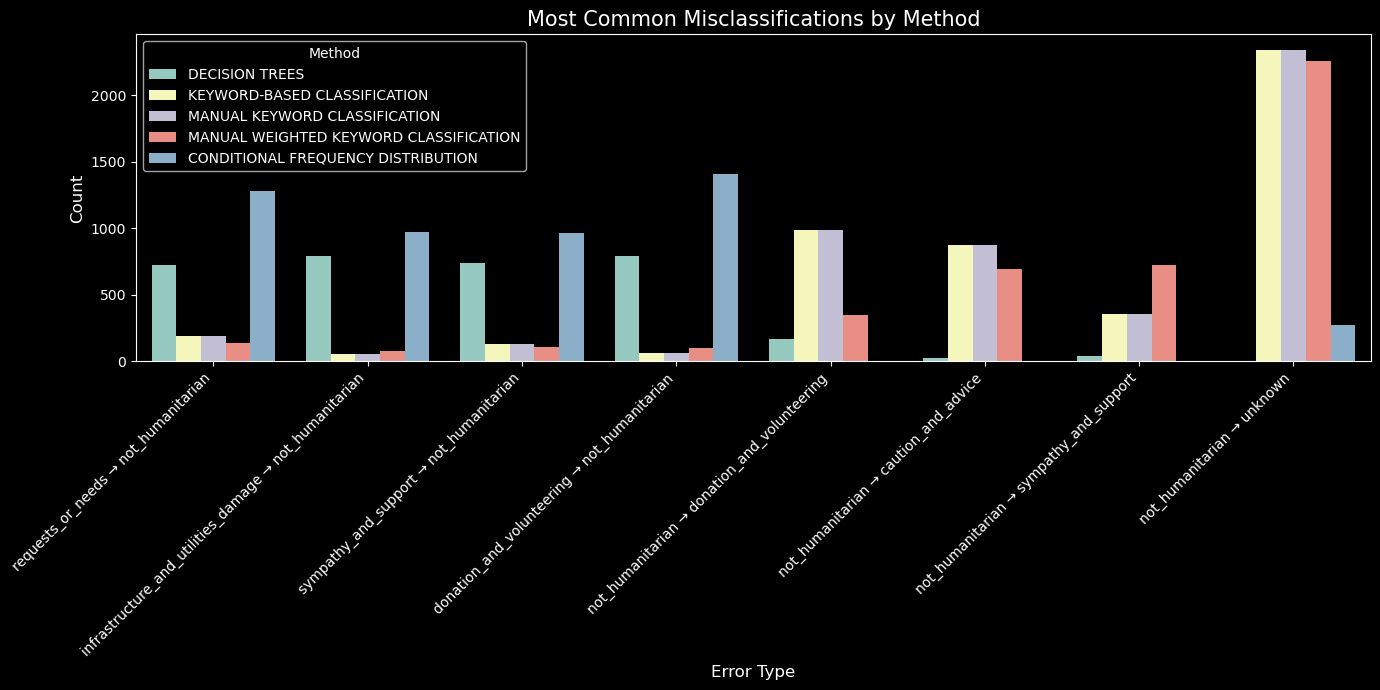

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap


=== METHOD COMPARISON ===

                                Method  Accuracy  Macro Avg F1  Weighted Avg F1  Macro Avg Precision  Macro Avg Recall
                        DECISION TREES    0.6836        0.3587           0.6285               0.6588            0.2887
          KEYWORD-BASED CLASSIFICATION    0.3929        0.3060           0.4496               0.3071            0.3929
         MANUAL KEYWORD CLASSIFICATION    0.3929        0.3060           0.4496               0.3071            0.3929
MANUAL WEIGHTED KEYWORD CLASSIFICATION    0.4230        0.3192           0.4834               0.3102            0.4159
    CONDITIONAL FREQUENCY DISTRIBUTION    0.5803        0.0792           0.4483               0.3751            0.0903

=== CATEGORY ANALYSIS ===

F1-Scores by Category:
Method                               CONDITIONAL FREQUENCY DISTRIBUTION  \
Category                                                                  
affected_individual                                      

c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andras.janko\AppData\Local\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [38]:
methods = ["DECISION TREES", "KEYWORD-BASED CLASSIFICATION", "MANUAL KEYWORD CLASSIFICATION", "MANUAL WEIGHTED KEYWORD CLASSIFICATION", "CONDITIONAL FREQUENCY DISTRIBUTION"]
method_names = {"DECISION TREES": "Method 1",
                "KEYWORD-BASED CLASSIFICATION": "Method 2",
                "MANUAL KEYWORD CLASSIFICATION": "Method 2.5",
                "MANUAL WEIGHTED KEYWORD CLASSIFICATION": "Method 2.75",
                "CONDITIONAL FREQUENCY DISTRIBUTION": "Method 3"}

predictions = [y_pred_method1_tfidf, y_pred_method2, y_pred_manual, y_pred_weighted, y_pred_method3]
accuracies = [accuracy_method1_tfidf, accuracy_method2, accuracy_manual, accuracy_weighted, accuracy_method3]

# 1. Accuracy comparison bar chart
plt.figure(figsize=(15, 6))
bars = plt.bar(methods, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Text Classification Methods', fontsize=15)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Add accuracy labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.4f}",
             ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Confusion matrices for all methods
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()
categories = sorted(df['class_label'].unique())

for i, (method, preds) in enumerate(zip(methods, predictions)):
    if i < len(axes):  # Make sure we don't exceed bounds
        conf_mat = confusion_matrix(y_test, preds)

        # Calculate accuracy per class
        class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)

        # Plot confusion matrix
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=categories, yticklabels=categories, ax=axes[i])
        axes[i].set_title(f'{method} ({method_names[method]})\nAccuracy: {accuracies[i]:.4f}', fontsize=14)
        axes[i].set_xlabel('Predicted Labels')
        axes[i].set_ylabel('True Labels')

# Hide the unused subplot
if len(methods) < len(axes):
    for idx in range(len(methods), len(axes)):
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# 3. Per-category performance across methods
categories = sorted(df['class_label'].unique())
category_metrics = []

for method_idx, (method, preds) in enumerate(zip(methods, predictions)):
    # Get classification report as dict
    report = classification_report(y_test, preds, output_dict=True)

    # Extract metrics for each category
    for category in categories:
        if category in report:
            precision = report[category]['precision']
            recall = report[category]['recall']
            f1 = report[category]['f1-score']
            support = report[category]['support']

            category_metrics.append({
                'Method': method,
                'Category': category,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'Support': support
            })

metrics_df = pd.DataFrame(category_metrics)

# Plot F1-scores by category
plt.figure(figsize=(14, 8))
pivot_table = metrics_df.pivot(index='Category', columns='Method', values='F1-Score')
ax = sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=0.5)
plt.title('F1-Score by Category and Method', fontsize=15)
plt.tight_layout()
plt.show()

# 4. Identification of most challenging categories
plt.figure(figsize=(14, 7))
sns.barplot(x='Category', y='F1-Score', hue='Method', data=metrics_df)
plt.title('F1-Score Comparison by Category', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title='Method')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Error analysis - finding common misclassifications
misclassification_counts = {}

for method_idx, (method, preds) in enumerate(zip(methods, predictions)):
    # Find misclassifications
    misclassified = [(true, pred) for true, pred in zip(y_test, preds) if true != pred]

    # Count by error type
    for true, pred in misclassified:
        key = f"{true} → {pred}"
        if key not in misclassification_counts:
            # Create a list with one entry for each method (5 methods)
            misclassification_counts[key] = [0, 0, 0, 0, 0]
        misclassification_counts[key][method_idx] += 1

# Convert to DataFrame and plot
error_data = []
for error_type, counts in misclassification_counts.items():
    for method_idx, count in enumerate(counts):
        error_data.append({
            'Error Type': error_type,
            'Method': methods[method_idx],
            'Count': count
        })

error_df = pd.DataFrame(error_data)

# Filter to show only the most common misclassifications
top_errors = error_df.groupby('Error Type')['Count'].sum().nlargest(8).index

plt.figure(figsize=(14, 7))
sns.barplot(x='Error Type', y='Count', hue='Method',
            data=error_df[error_df['Error Type'].isin(top_errors)])
plt.title('Most Common Misclassifications by Method', fontsize=15)
plt.xlabel('Error Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Method')
plt.tight_layout()
plt.show()

# 6. Summary table of all metrics
summary_data = []
for method_idx, (method, preds) in enumerate(zip(methods, predictions)):
    report = classification_report(y_test, preds, output_dict=True)

    summary_data.append({
        'Method': method,
        'Accuracy': accuracies[method_idx],
        'Macro Avg F1': report['macro avg']['f1-score'],
        'Weighted Avg F1': report['weighted avg']['f1-score'],
        'Macro Avg Precision': report['macro avg']['precision'],
        'Macro Avg Recall': report['macro avg']['recall']
    })

summary_df = pd.DataFrame(summary_data)

print("\n=== METHOD COMPARISON ===\n")
print(summary_df.round(4).to_string(index=False))

print("\n=== CATEGORY ANALYSIS ===\n")
pivot_f1 = metrics_df.pivot(index='Category', columns='Method', values='F1-Score')
print("F1-Scores by Category:")
print(pivot_f1.round(4))

# 7. Find the best method for each category
best_method_by_category = pivot_f1.idxmax(axis=1)
print("\nBest Method for Each Category:")
for category, best_method in best_method_by_category.items():
    best_f1 = pivot_f1.loc[category, best_method]
    print(f"{category}: {best_method} (F1={best_f1:.4f})")